In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from nanonets.utils import fft, generate_band_limited_noise

plt.style.use(["science","bright","grid"])

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
AMPLITUDE    = 0.01
BANDWIDTH_HZ = 4.35e9
DURATION     = 20e-6
DT           = 1e-11
t, x         = generate_band_limited_noise(DURATION, BANDWIDTH_HZ, DT, is_pink=True)
xf, yf       = fft(x, DT)

(0.0001, 0.22182345802911782)

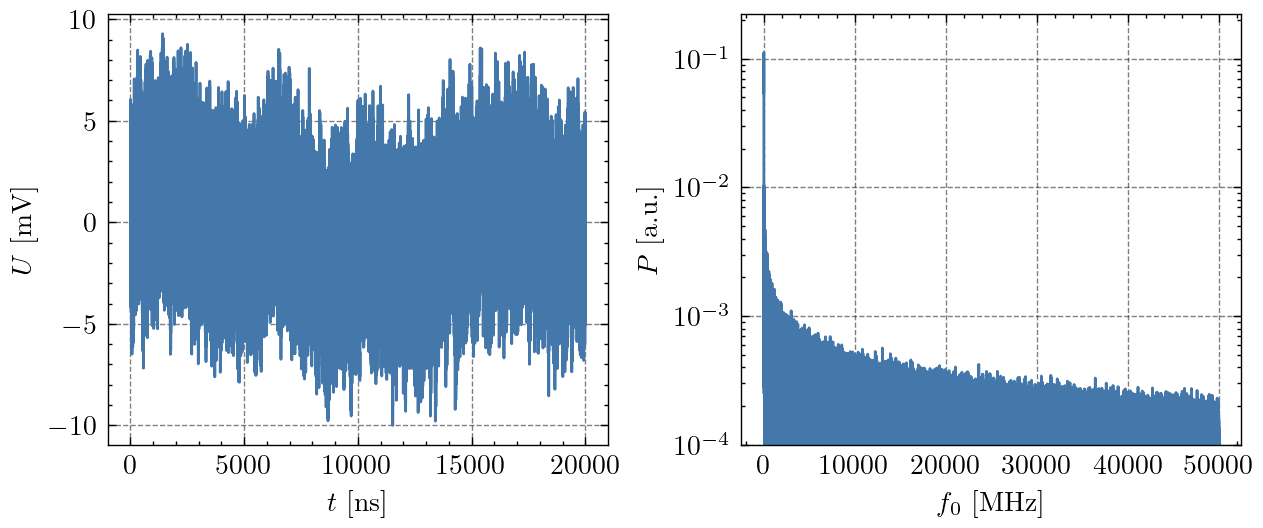

In [ ]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot(1,2,1)
ax.plot(t*1e9, x*1000)
ax.set_ylabel("$U$ [mV]")
ax.set_xlabel("$t$ [ns]")
ax  = fig.add_subplot(1,2,2)
ax.plot(xf*1e-6, yf)
ax.set_ylabel("$P$ [a.u.]")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_yscale('log')
ax.set_ylim(1e-4)

In [19]:
1/0.23

4.3478260869565215

In [ ]:
def mutual_information(x: np.ndarray, y: np.ndarray, num_bins: int) -> float:
    """
    Calculates the Mutual Information between two continuous time series.

    The function discretizes the continuous signals into a 2D histogram and then
    computes the Mutual Information I(X; Y) = H(X) + H(Y) - H(X, Y), where H
    is the Shannon entropy.

    Args:
        x (np.ndarray): The first time series (e.g., input voltage).
        y (np.ndarray): The second time series (e.g., output current).
                        Must have the same length as x.
        num_bins (int): The number of bins to use for discretizing each variable.
                        This is a crucial parameter that affects the result.

    Returns:
        float: The Mutual Information between x and y in bits.
    """
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    if len(x) == 0:
        return 0.0

    # 1. Create the 2D histogram from the data.
    # This gives us the joint counts of (x, y) pairs.
    joint_hist, _, _ = np.histogram2d(x, y, bins=num_bins)

    # 2. Convert the joint counts to a joint probability distribution.
    joint_prob = joint_hist / np.sum(joint_hist)

    # 3. Calculate the marginal probabilities by summing over rows and columns.
    marginal_prob_x = np.sum(joint_prob, axis=1)
    marginal_prob_y = np.sum(joint_prob, axis=0)

    # 4. Calculate the individual entropies and the joint entropy.
    # We only sum over non-zero probabilities, as log2(0) is undefined.
    
    # Entropy of X: H(X)
    h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
    
    # Entropy of Y: H(Y)
    h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
    
    # Joint Entropy of X and Y: H(X, Y)
    h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)

    # 5. Calculate Mutual Information: I(X; Y) = H(X) + H(Y) - H(X, Y)
    mi = h_x + h_y - h_xy
    
    return mi

def mutual_information_corrected(x: np.ndarray, y: np.ndarray, num_bins: int) -> tuple[float, float]:
    """
    Calculates the Mutual Information with Miller-Madow bias correction.
    """
    if len(x) != len(y):
        raise ValueError("Input arrays must have the same length.")
    N = len(x)
    if N == 0:
        return 0.0, 0.0

    joint_hist, _, _ = np.histogram2d(x, y, bins=num_bins)
    joint_prob = joint_hist / N

    marginal_prob_x = np.sum(joint_prob, axis=1)
    marginal_prob_y = np.sum(joint_prob, axis=0)
    
    # --- Naive MI Calculation (as before) ---
    h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
    h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
    h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)
    mi_naive = h_x + h_y - h_xy

    # --- Miller-Madow Bias Correction ---
    # Count the number of non-empty bins
    b_xy = np.count_nonzero(joint_hist)
    b_x = np.count_nonzero(np.sum(joint_hist, axis=1))
    b_y = np.count_nonzero(np.sum(joint_hist, axis=0))
    
    bias = (b_xy - b_x - b_y) / (2 * N * np.log(2))
    
    mi_corrected = mi_naive - bias
    
    # Corrected MI cannot be negative
    return max(0, mi_corrected), mi_naive

150000000.0

In [ ]:
NUM_SAMPLES     = 16384 
BANDWIDTH_HZ    = 150e6
t, x            = generate_band_limited_white_noise(NUM_SAMPLES, BANDWIDTH_HZ)

V_fft           = fft(x)
freqs           = fftfreq(len(x), t[1] - t[0])
freqs_shifted   = fftshift(freqs)
psd_shifted     = fftshift(np.abs(V_fft)**2)

Text(0.5, 0, '$f_0$ [MHz]')

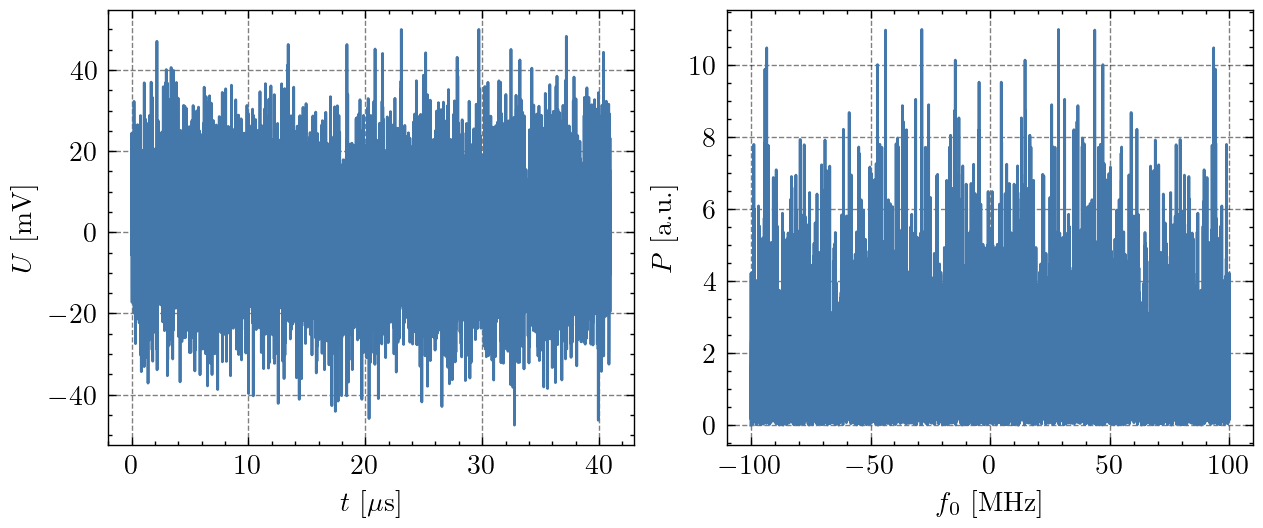

In [165]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax  = fig.add_subplot(1,2,1)
ax.plot(t*1e6, x*1000)
ax.set_ylabel("$U$ [mV]")
ax.set_xlabel("$t$ [$\mu$s]")
ax  = fig.add_subplot(1,2,2)
ax.plot(freqs_shifted / 1e6, psd_shifted)
ax.set_ylabel("$P$ [a.u.]")
ax.set_xlabel("$f_0$ [MHz]")

In [236]:
NUM_SAMPLES     = 65536 
BANDWIDTH_HZ    = 100e6
STAT_SIZE       = 1000
N_NP            = 9
N_E             = 8
topo            = {"Nx": N_NP,"Ny": N_NP,
                    "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
                        [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
                        [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]
                        ],
                    "electrode_type": ['constant']*N_E}
t_vals, in_vals = generate_band_limited_white_noise(NUM_SAMPLES, BANDWIDTH_HZ, 1.0)
volt            = np.zeros(shape=(NUM_SAMPLES,N_E+1))
volt[:,0]       = in_vals
sim_class       = Simulation(topo, pack_optimizer=False)
sim_class.run_dynamic_voltages(volt, t_vals, N_E-1)

In [237]:
t   = t_vals.copy()[:-1]*1e6
x   = in_vals.copy()[1:]*1e3
y   = sim_class.get_observable_storage()*1e-6
y_e = sim_class.get_observable_error_storage()*1e-6

In [246]:
(t[1]-t[0])*1e-6

5e-09

Text(0, 0.5, '$I$ [pA]')

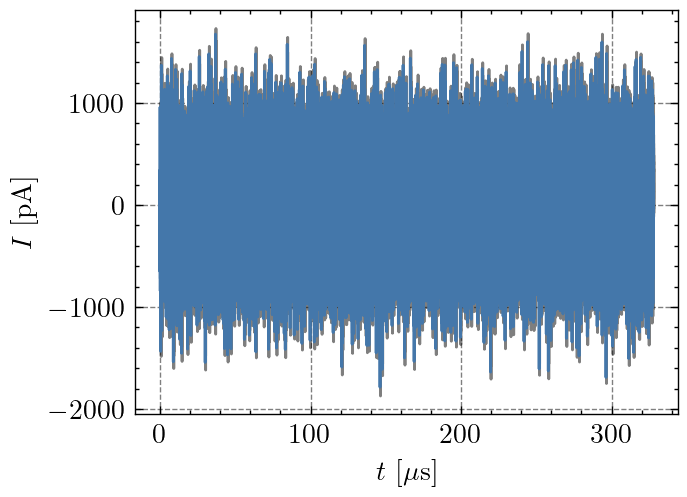

In [243]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(t,y)
ax.fill_between(t, y-y_e, y+y_e, color='black', alpha=0.5)
ax.set_xlabel("$t$ [$\mu$s]")
ax.set_ylabel("$I$ [pA]")
# ax.set_xlim(0,1)

Text(0, 0.5, '$I$ [pA]')

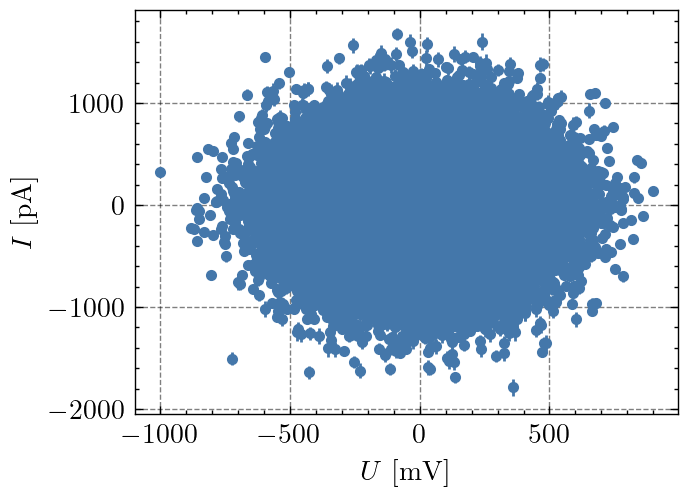

In [239]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.errorbar(x, y, y_e, marker='.', ls='')
ax.set_xlabel("$U$ [mV]")
ax.set_ylabel("$I$ [pA]")

/tmp/ipykernel_1449/1427381408.py:106: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
/tmp/ipykernel_1449/1427381408.py:107: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
/tmp/ipykernel_1449/1427381408.py:108: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)


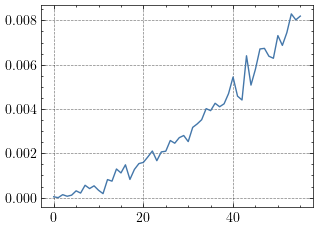

In [240]:
num_bins = np.arange(8,64,1)
mi       = [mutual_information_corrected(x, y, n)[0] for n in num_bins]
plt.plot(mi)

In [241]:
from sklearn.feature_selection import mutual_info_regression

# Note: scikit-learn expects inputs of shape (n_samples, n_features)
# So we need to reshape our 1D arrays.
x_reshaped = x.reshape(-1, 1) # Replace x with your data

# n_neighbors is the key parameter here, similar to num_bins.
# The default is 3, which is a good starting point.
mi_knn = mutual_info_regression(x_reshaped, y, n_neighbors=5)[0]

# The result is in "nats", so we convert to "bits"
mi_knn_bits = mi_knn / np.log(2)
mi_knn_bits

0.0026176995464021013

/tmp/ipykernel_1449/1427381408.py:106: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_x = -np.sum(p * np.log2(p) for p in marginal_prob_x if p > 0)
/tmp/ipykernel_1449/1427381408.py:107: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_y = -np.sum(p * np.log2(p) for p in marginal_prob_y if p > 0)
/tmp/ipykernel_1449/1427381408.py:108: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  h_xy = -np.sum(p * np.log2(p) for p in joint_prob.flatten() if p > 0)


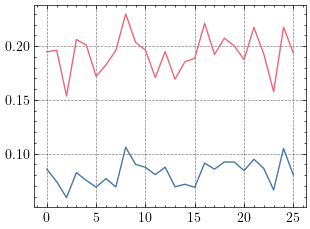

In [242]:
def mutual_info_bits(x, y):
    x_reshaped = x.reshape(-1, 1)
    mi_knn = mutual_info_regression(x_reshaped, y, n_neighbors=5)[0]
    mi_knn_bits = mi_knn / np.log(2)
    return mi_knn_bits

n = 2500
# mi_knn_bits = [mutual_info_bits(x[i*n:(i+1)*n],y[i*n:(i+1)*n]) for i in range(6)]
mi_chunks   = [mutual_information_corrected(x[i*n:(i+1)*n],y[i*n:(i+1)*n], num_bins=32) for i in range(NUM_SAMPLES//n)]
plt.plot(mi_chunks)